In [2]:
import pandas as pd
import numpy as np
import datetime 
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn; seaborn.set()

In [59]:
df = pd.read_csv('valeurs_mensuelles-IDF-train-ftra.csv',sep=';',decimal=',')
df.head()

,Months,NH_IDF
0,01/01/2010,2462.71
1,01/02/2010,2303.15
2,01/03/2010,2828.36
3,01/04/2010,2714.11
4,01/05/2010,2911.72


In [60]:
df['Date'] = pd.to_datetime(df.Months,format='%d/%m/%Y')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101 entries, 0 to 100
Data columns (total 3 columns):
Months    101 non-null object
NH_IDF    101 non-null float64
Date      101 non-null datetime64[ns]
dtypes: datetime64[ns](1), float64(1), object(1)
memory usage: 2.4+ KB


In [61]:
df = df.set_index('Date')
df.head(3)

,Months,NH_IDF
Date,,
2010-01-01,01/01/2010,2462.71
2010-02-01,01/02/2010,2303.15
2010-03-01,01/03/2010,2828.36


In [66]:
df.index[1].month

2

In [67]:
df.isnull().sum()

Months    0
NH_IDF    0
dtype: int64

In [63]:
df = df.sort_values(by='Date')
df.head(3)

,Months,NH_IDF
Date,,
2010-01-01,01/01/2010,2462.71
2010-02-01,01/02/2010,2303.15
2010-03-01,01/03/2010,2828.36


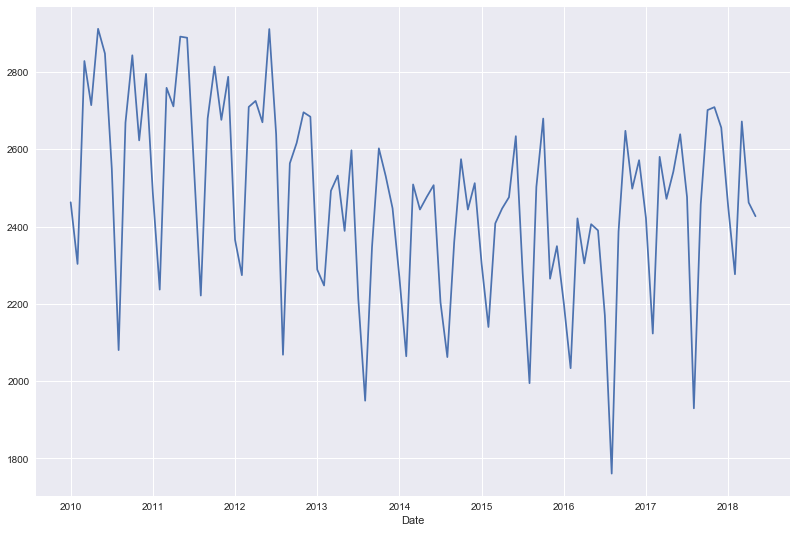

In [65]:
#Plotting number of booked nights in time series
df['NH_IDF'].plot(figsize=(13.5,9));

In [72]:
#Seasonal difference
df['SD_NH_IDF'] = df['NH_IDF'] - df['NH_IDF'].shift(12)
df.isnull().sum()

Months        0
NH_IDF        0
SD_NH_IDF    12
dtype: int64

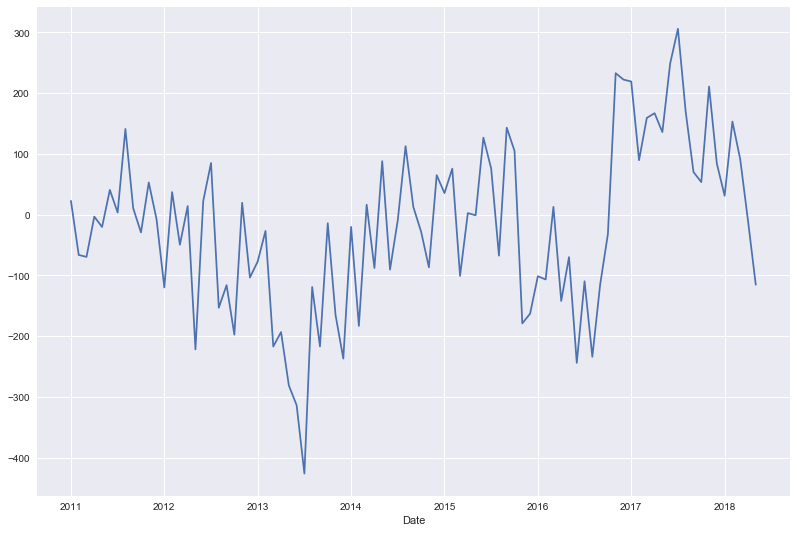

In [74]:
df['SD_NH_IDF'].plot(figsize=(13.5,9));

In [76]:
#1st seasonal difference
df['1DSD_NH_IDF'] = df['SD_NH_IDF'] - df['SD_NH_IDF'].shift(1)
df.isnull().sum()

Months          0
NH_IDF          0
SD_NH_IDF      12
1DSD_NH_IDF    13
dtype: int64

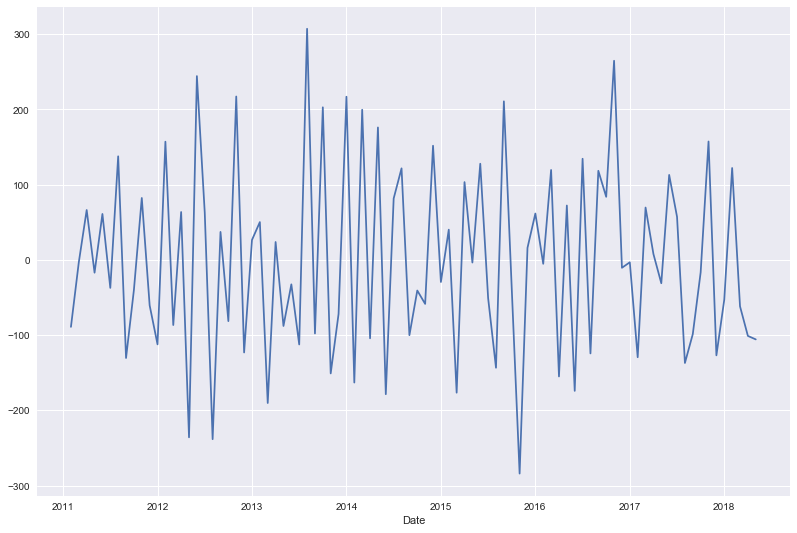

In [78]:
df['1DSD_NH_IDF'].plot(figsize=(13.5,9));
#TS has been made stationary

In [80]:
df['1DSD_NH_IDF'].describe()

count     88.000000
mean      -1.568864
std      127.145406
min     -284.090000
25%     -100.415000
50%      -13.540000
75%       82.675000
max      307.170000
Name: 1DSD_NH_IDF, dtype: float64

In [94]:
#ACF and PACF plots:
from statsmodels.tsa.stattools import acf, pacf

df_ADSD_NH_IDF = df['1DSD_NH_IDF'].dropna()

lag_acf = acf(df_ADSD_NH_IDF, nlags=37)
lag_pacf = pacf(df_ADSD_NH_IDF, nlags=37, method='ols')
lag_acf

array([ 1.00000000e+00, -4.40740967e-01,  9.80003710e-02, -1.52805910e-01,
        9.69702562e-02,  4.30105990e-02, -2.22291483e-01,  2.11078770e-01,
       -4.28536556e-02,  1.10707308e-01, -1.41885357e-01,  9.26234477e-02,
       -2.14072607e-01,  5.35978587e-02,  3.85360163e-02, -1.86574943e-04,
        9.39059214e-02, -1.96614292e-01,  2.03530218e-01, -1.91870511e-01,
       -3.43746087e-03,  8.02042816e-02, -5.80558410e-02,  8.01188767e-02,
       -1.13706308e-01,  4.67714231e-02,  1.20606293e-01, -2.12166867e-01,
        1.42103098e-02,  1.17857111e-01,  9.08876754e-03,  5.08168318e-02,
       -6.90176264e-02,  1.27324098e-02,  1.36105092e-02,  3.67381401e-02,
       -5.57132347e-02, -1.88976235e-02])

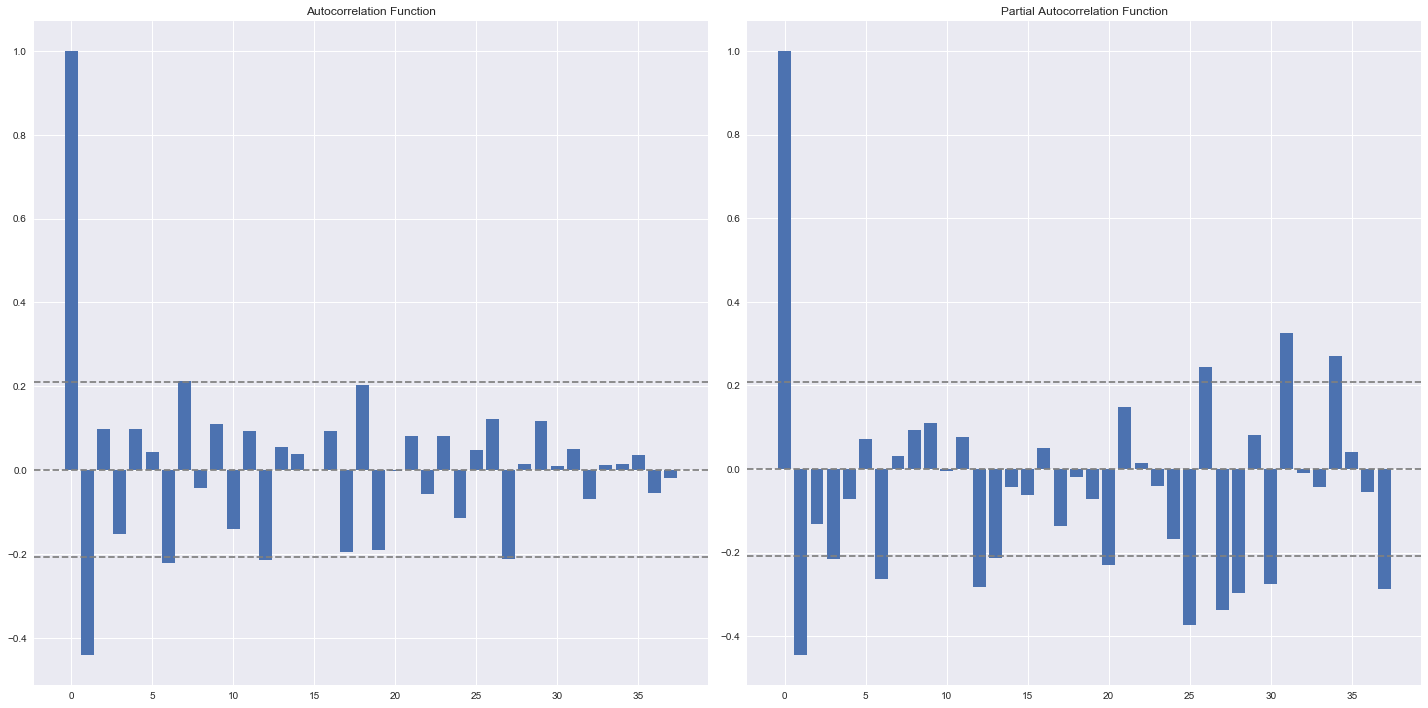

In [96]:
plt.figure(figsize=(20,10))
#Plot ACF: 
plt.subplot(121) 
plt.bar(range(len(lag_acf)),lag_acf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(df_ADSD_NH_IDF)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(df_ADSD_NH_IDF)),linestyle='--',color='gray')
plt.title('Autocorrelation Function')
#Plot PACF:
plt.subplot(122)
plt.bar(range(len(lag_pacf)),lag_pacf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(df_ADSD_NH_IDF)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(df_ADSD_NH_IDF)),linestyle='--',color='gray')
plt.title('Partial Autocorrelation Function')
plt.tight_layout()

# p – The lag value where the PACF chart crosses the upper confidence interval for the first time
# q – The lag value where the ACF chart crosses the upper confidence interval for the first time

In [122]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

mod = SARIMAX(df['NH_IDF'], order=(0,1,1), seasonal_order=(0,1,2,12),enforce_invertibility=False)
results = mod.fit()

y_pred = results.predict(start = 100, end= 106, dynamic= True)

C:\Users\franc\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\franc\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


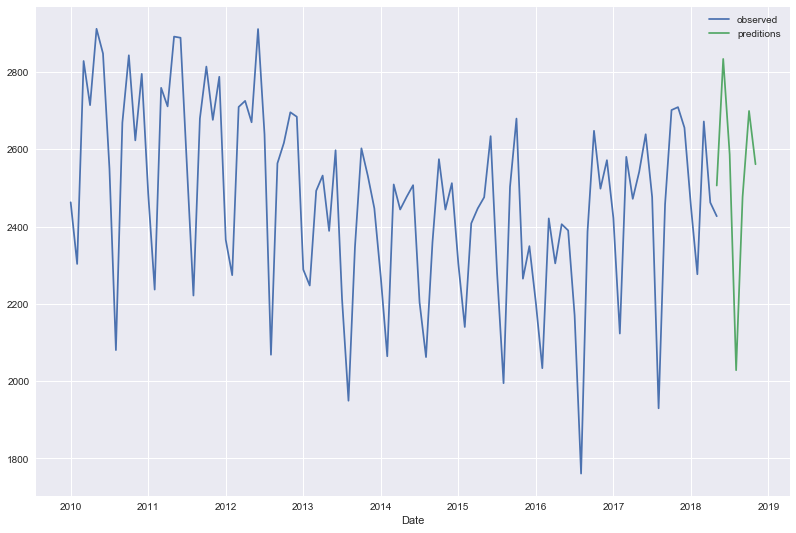

In [123]:
#len(y_pred)
df['NH_IDF'].plot(figsize=(13.5,9),label='observed')
y_pred.plot(figsize=(13.5,9),label='preditions')
plt.legend()
plt.show()